In [8]:
# INICIAR
from main import main
from PDconfig import *
from frames.archivosDF import *
import pandas as pd

main()
df = abrirDF(ZonaP)

In [9]:
# FILTRADO DE DATOS GENERAL
df.drop_duplicates(subset='id', keep='last', inplace=True, ignore_index=False)
df.dropna(how="all", subset=['terrenoTotal', 'terrenoEdificado'], inplace=True)

df['fechaUltimaActualizacion'] = pd.to_datetime(df['fechaUltimaActualizacion'], format='%d-%m-%Y')
df['fechaUltimaActualizacion'] = df['fechaUltimaActualizacion'].dt.strftime('%d-%m-%Y')

df.sort_values(by='fechaUltimaActualizacion', ascending=False, inplace=True)
df.drop_duplicates(subset=['coordX', 'coordY', 'precioUSD'], inplace=True, ignore_index=True)

# ELIMINAR TIPO PROP INSERVIBLES
filt = df['tipoPropiedad'] == 'PH'
df.loc[filt, 'tipoPropiedad'] = "DEPARTAMENTO"

# ELIMINAR DATOS SIN CAMPOS RELEVANTES
filtro_T = (df['terrenoEdificado'] == 1)
filtro_P = ((df['precioUSD'] == 1))
df.drop(df[filtro_T | filtro_P].index, inplace=True)

In [10]:
# SEPARAR y FILTRAR TIPOS PROPIEDADES
terrenos = df.loc[df["tipoPropiedad"] == "TERRENOS"]
casas = df.loc[df["tipoPropiedad"] == "CASA"]
deptos = df.loc[df["tipoPropiedad"] == "DEPARTAMENTO"]

# FILTRADO DEPARTAMENTOS
filt1 = (deptos['terrenoEdificado'] < 15) | (deptos['terrenoEdificado'].isna())
filt2 = deptos['terrenoTotal'].notna()
deptos.loc[filt1 & filt2, 'terrenoEdificado'] = deptos.loc[filt1 & filt2, 'terrenoTotal']

filtro_P = deptos["precioUSD"].between(deptos["precioUSD"].quantile(0.005), 
                                       deptos["precioUSD"].quantile(0.995))
filtro_E = (deptos["terrenoEdificado"].between(15, 500))
deptos = deptos.loc[filtro_P & filtro_E]

# FILTRADO CASAS
filt1 = (casas['terrenoTotal'] < casas['terrenoEdificado'])
total = casas.loc[filt1, 'terrenoTotal']
edif = casas.loc[filt1, 'terrenoEdificado']
casas.loc[filt1, 'terrenoTotal'] = edif
casas.loc[filt1, 'terrenoEdificado'] = total

filtro_P = casas["precioUSD"].between(casas["precioUSD"].quantile(0.005), 
                                       casas["precioUSD"].quantile(0.995))
filtro_E = casas['terrenoEdificado'].between(25, 2000)
filtro_T = (casas['terrenoTotal'].between(casas['terrenoTotal'].quantile(0.001),
                                         casas['terrenoTotal'].quantile(0.999))) | casas['terrenoTotal'].isna()
casas = casas.loc[filtro_P & filtro_E & filtro_T]

# FILTRADO TERRENOS
filtro_P = terrenos["precioUSD"].between(1500, terrenos["precioUSD"].quantile(0.995))
filtro_T = (terrenos['terrenoTotal'].between(terrenos['terrenoTotal'].quantile(0.005),
                                             terrenos['terrenoTotal'].quantile(0.995)))
terrenos = terrenos.loc[filtro_P & filtro_T]

70


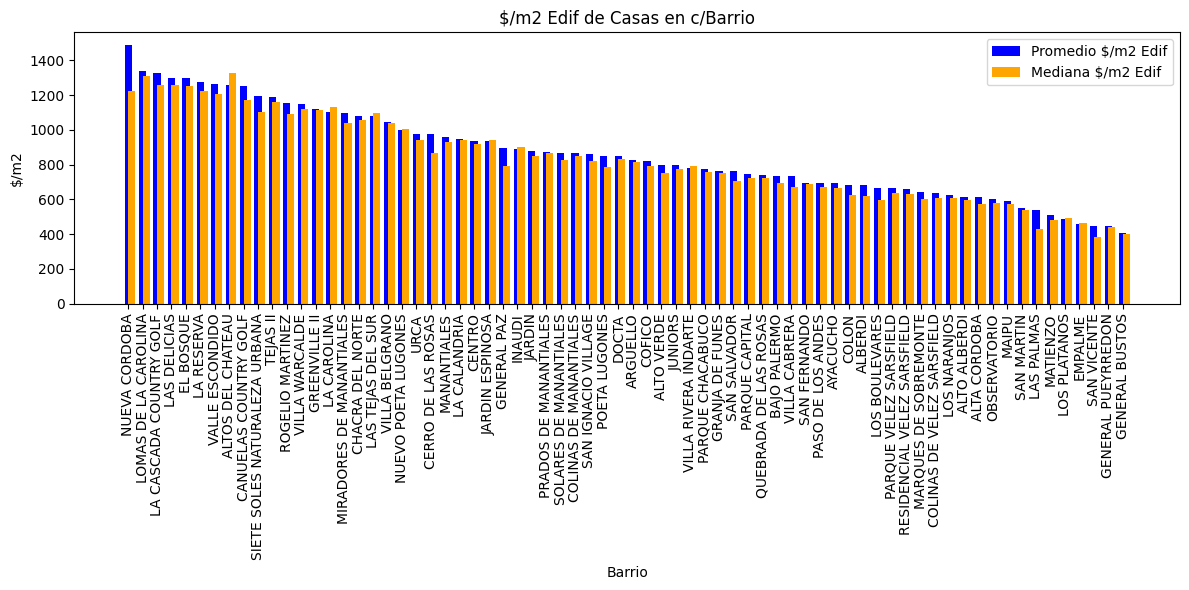

In [11]:
# ANALISIS CASAS
casas['$/m2_total'] = casas['precioUSD'] / casas['terrenoTotal']
casas['$/m2_edif'] = casas['precioUSD'] / casas['terrenoEdificado']

casas_filt = casas.loc[casas['ciudad'] == 'CORDOBA']
barrios = casas_filt.groupby(['ciudad', 'barrio'])

precio_m2_total_prom = barrios['$/m2_total'].mean().round(0)
precio_m2_total_med = barrios['$/m2_total'].median().round(0)
precio_m2_edif_prom = barrios['$/m2_edif'].mean().round(0)
precio_m2_edif_med = barrios['$/m2_edif'].median().round(0)
cantidad = barrios.size()

# Create a new DataFrame to store the calculated data
resultados = pd.DataFrame({
    'Precio_m2_total_promedio': precio_m2_total_prom,
    'Precio_m2_total_mediana': precio_m2_total_med,
    'Precio_m2_edif_promedio': precio_m2_edif_prom,
    'Precio_m2_edif_mediana': precio_m2_edif_med,
    'Cantidad': cantidad
})
resultados.reset_index(inplace=True)

results_df = resultados[['barrio', 'Precio_m2_edif_promedio', 'Precio_m2_edif_mediana', 'Precio_m2_total_promedio', 'Precio_m2_total_mediana', 'Cantidad']]
# Assuming you have a DataFrame named 'results_df' and you want to save it to an Excel file named 'results.xlsx'
results_df.to_excel('./DataFrames/ZonaP/Analisis/Inmuebles/casas_barrios_ZP.xlsx', index=False)


import matplotlib.pyplot as plt


resultados['indice'] = (resultados['Precio_m2_edif_promedio'] + resultados['Precio_m2_edif_mediana'])/2
resultados.sort_values("Precio_m2_edif_promedio", ascending=False, inplace=True)
resultados = resultados[(resultados["Cantidad"] > 20)]
plt.figure(figsize=(12, 6))
barrio_names = resultados['barrio']
print(len(barrio_names))
bar_width = 0.5


# Plot the bar for average house cost
plt.bar(barrio_names, resultados['Precio_m2_edif_promedio'], width=bar_width, label='Promedio $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, resultados['Precio_m2_edif_mediana'], width=bar_width, label='Mediana $/m2 Edif', color='orange', align='edge')

#plt.bar(barrio_names, resultados['indice'], width=bar_width, label='Indice Precio', color='blue')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('$/m2 Edif de Casas en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


33


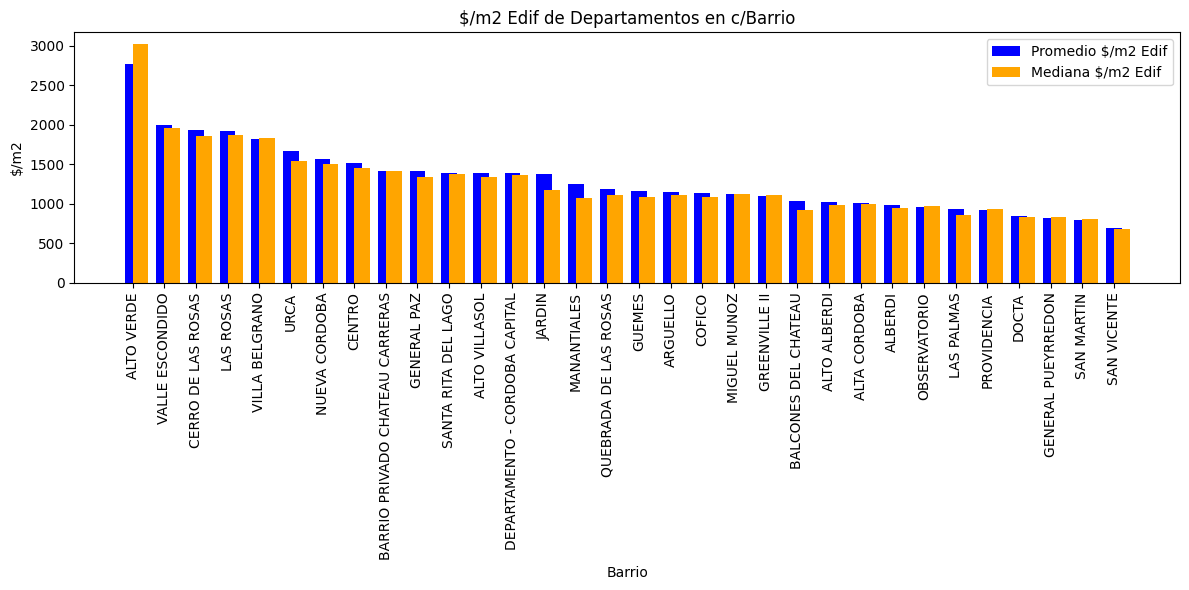

In [12]:
# ANALISIS DEPARTAMENTOS
deptos['$/m2_total'] = deptos['precioUSD'] / deptos['terrenoTotal']
deptos['$/m2_edif'] = deptos['precioUSD'] / deptos['terrenoEdificado']

barrios = deptos.groupby(['ciudad', 'barrio'])

precio_m2_total_prom = barrios['$/m2_total'].mean().round(0)
precio_m2_total_med = barrios['$/m2_total'].median().round(0)
precio_m2_edif_prom = barrios['$/m2_edif'].mean().round(0)
precio_m2_edif_med = barrios['$/m2_edif'].median().round(0)
cantidad = barrios.size()

# Create a new DataFrame to store the calculated data
resultados = pd.DataFrame({
    'Precio_m2_total_promedio': precio_m2_total_prom,
    'Precio_m2_total_mediana': precio_m2_total_med,
    'Precio_m2_edif_promedio': precio_m2_edif_prom,
    'Precio_m2_edif_mediana': precio_m2_edif_med,
    'Cantidad': cantidad
})
resultados.reset_index(inplace=True)

results_df = resultados[['barrio', 'Precio_m2_edif_promedio', 'Precio_m2_edif_mediana', 'Precio_m2_total_promedio', 'Precio_m2_total_mediana', 'Cantidad']]
# Assuming you have a DataFrame named 'results_df' and you want to save it to an Excel file named 'results.xlsx'
results_df.to_excel('./DataFrames/ZonaP/Analisis/Inmuebles/deptos_barrios_ZP.xlsx', index=False)

import matplotlib.pyplot as plt


resultados['indice'] = (resultados['Precio_m2_edif_promedio'] + resultados['Precio_m2_edif_mediana'])/2
resultados.sort_values("Precio_m2_edif_promedio", ascending=False, inplace=True)
resultados = resultados[(resultados["Cantidad"] > 20)]
plt.figure(figsize=(12, 6))
barrio_names = resultados['barrio']
print(len(barrio_names))
bar_width = 0.5


# Plot the bar for average house cost
plt.bar(barrio_names, resultados['Precio_m2_edif_promedio'], width=bar_width, label='Promedio $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, resultados['Precio_m2_edif_mediana'], width=bar_width, label='Mediana $/m2 Edif', color='orange', align='edge')

#plt.bar(barrio_names, resultados['indice'], width=bar_width, label='Indice Precio', color='blue')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('$/m2 Edif de Departamentos en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


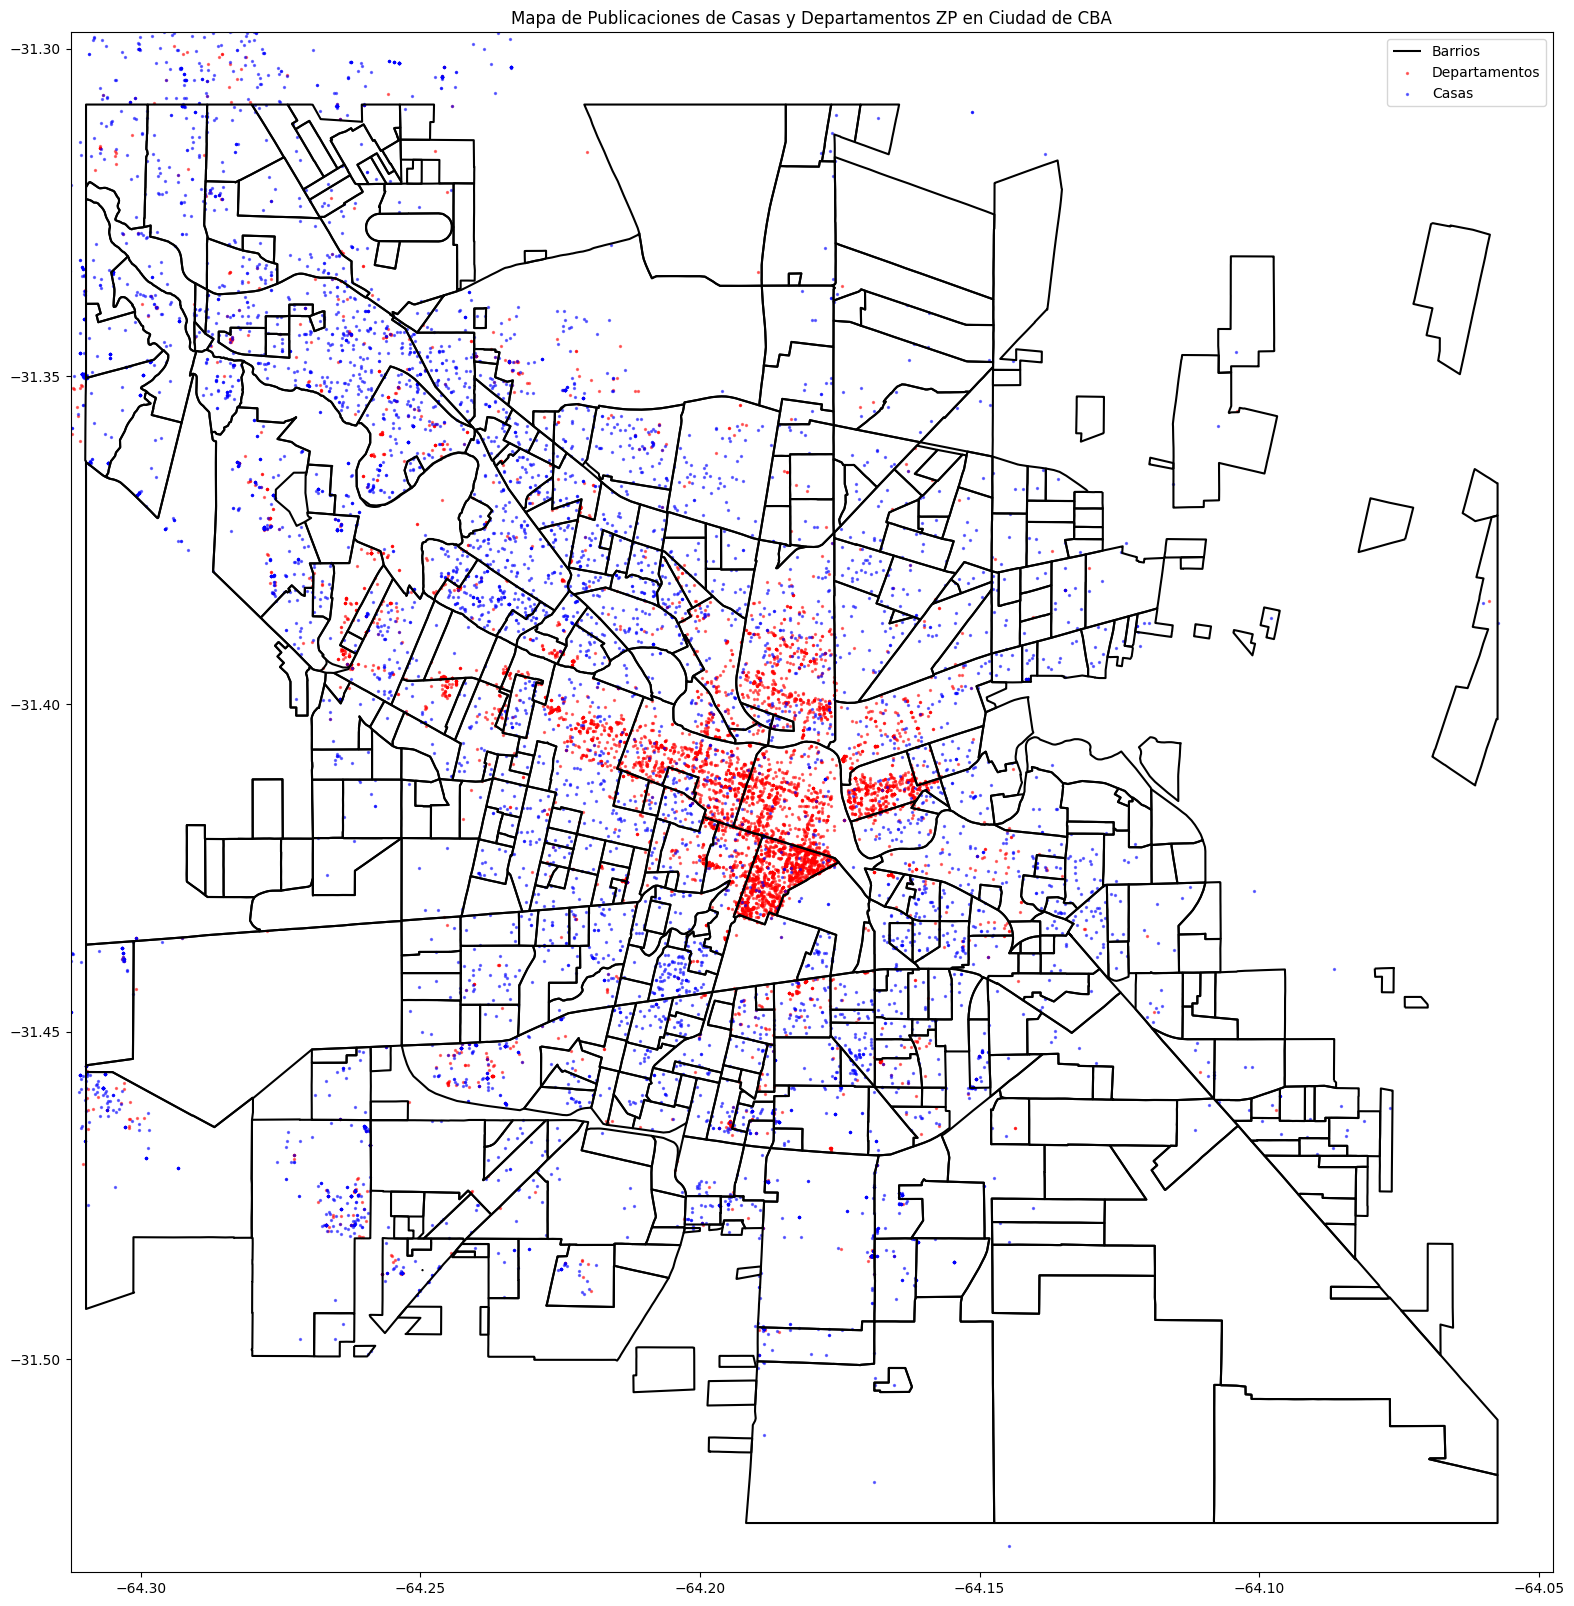

In [15]:
# MAPA COMBINADO (C y D) CIUDAD DE CBA
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj


filt = casas['coordX'].notna()
ubicados_c = casas[filt]
filt = deptos['coordX'].notna()
ubicados_d = deptos[filt]

# Define the source and target coordinate systems
source_crs = pyproj.CRS("EPSG:4326")  # WGS84 (latitude and longitude)
# Create a transformer
latitudes_d, longitudes_d = ubicados_d['coordX'], ubicados_d['coordY']
latitudes_c, longitudes_c = ubicados_c['coordX'], ubicados_c['coordY']

# Read the shapefiles
barrios_shp = './utils/maps/barrios.shp'
barrios = gpd.read_file(barrios_shp)
center = (-64.18365408774824, -31.41675384652835)


# Create a plot with the boundaries of both shapefiles
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the boundaries of radios_urbanos shapefile
barrios.boundary.plot(ax=ax, color='black', label='Barrios')

# Plot the transformed points with smaller markers and more transparency
ax.scatter(longitudes_d, latitudes_d, color='red', label='Departamentos', s=2, alpha=0.5)
ax.scatter(longitudes_c, latitudes_c, color='blue', label='Casas', s=2, alpha=0.5)

map_padding = 0.0125  # Increase the padding for more zoom-out effect
ax.set_xlim(-64.30-map_padding, -64.06 + map_padding)
ax.set_ylim(-31.52-map_padding, -31.31 + map_padding)

# Set the title and legend
ax.set_title('Mapa de Publicaciones de Casas y Departamentos ZP en Ciudad de CBA')
ax.legend()

# Show the plot
plt.show()


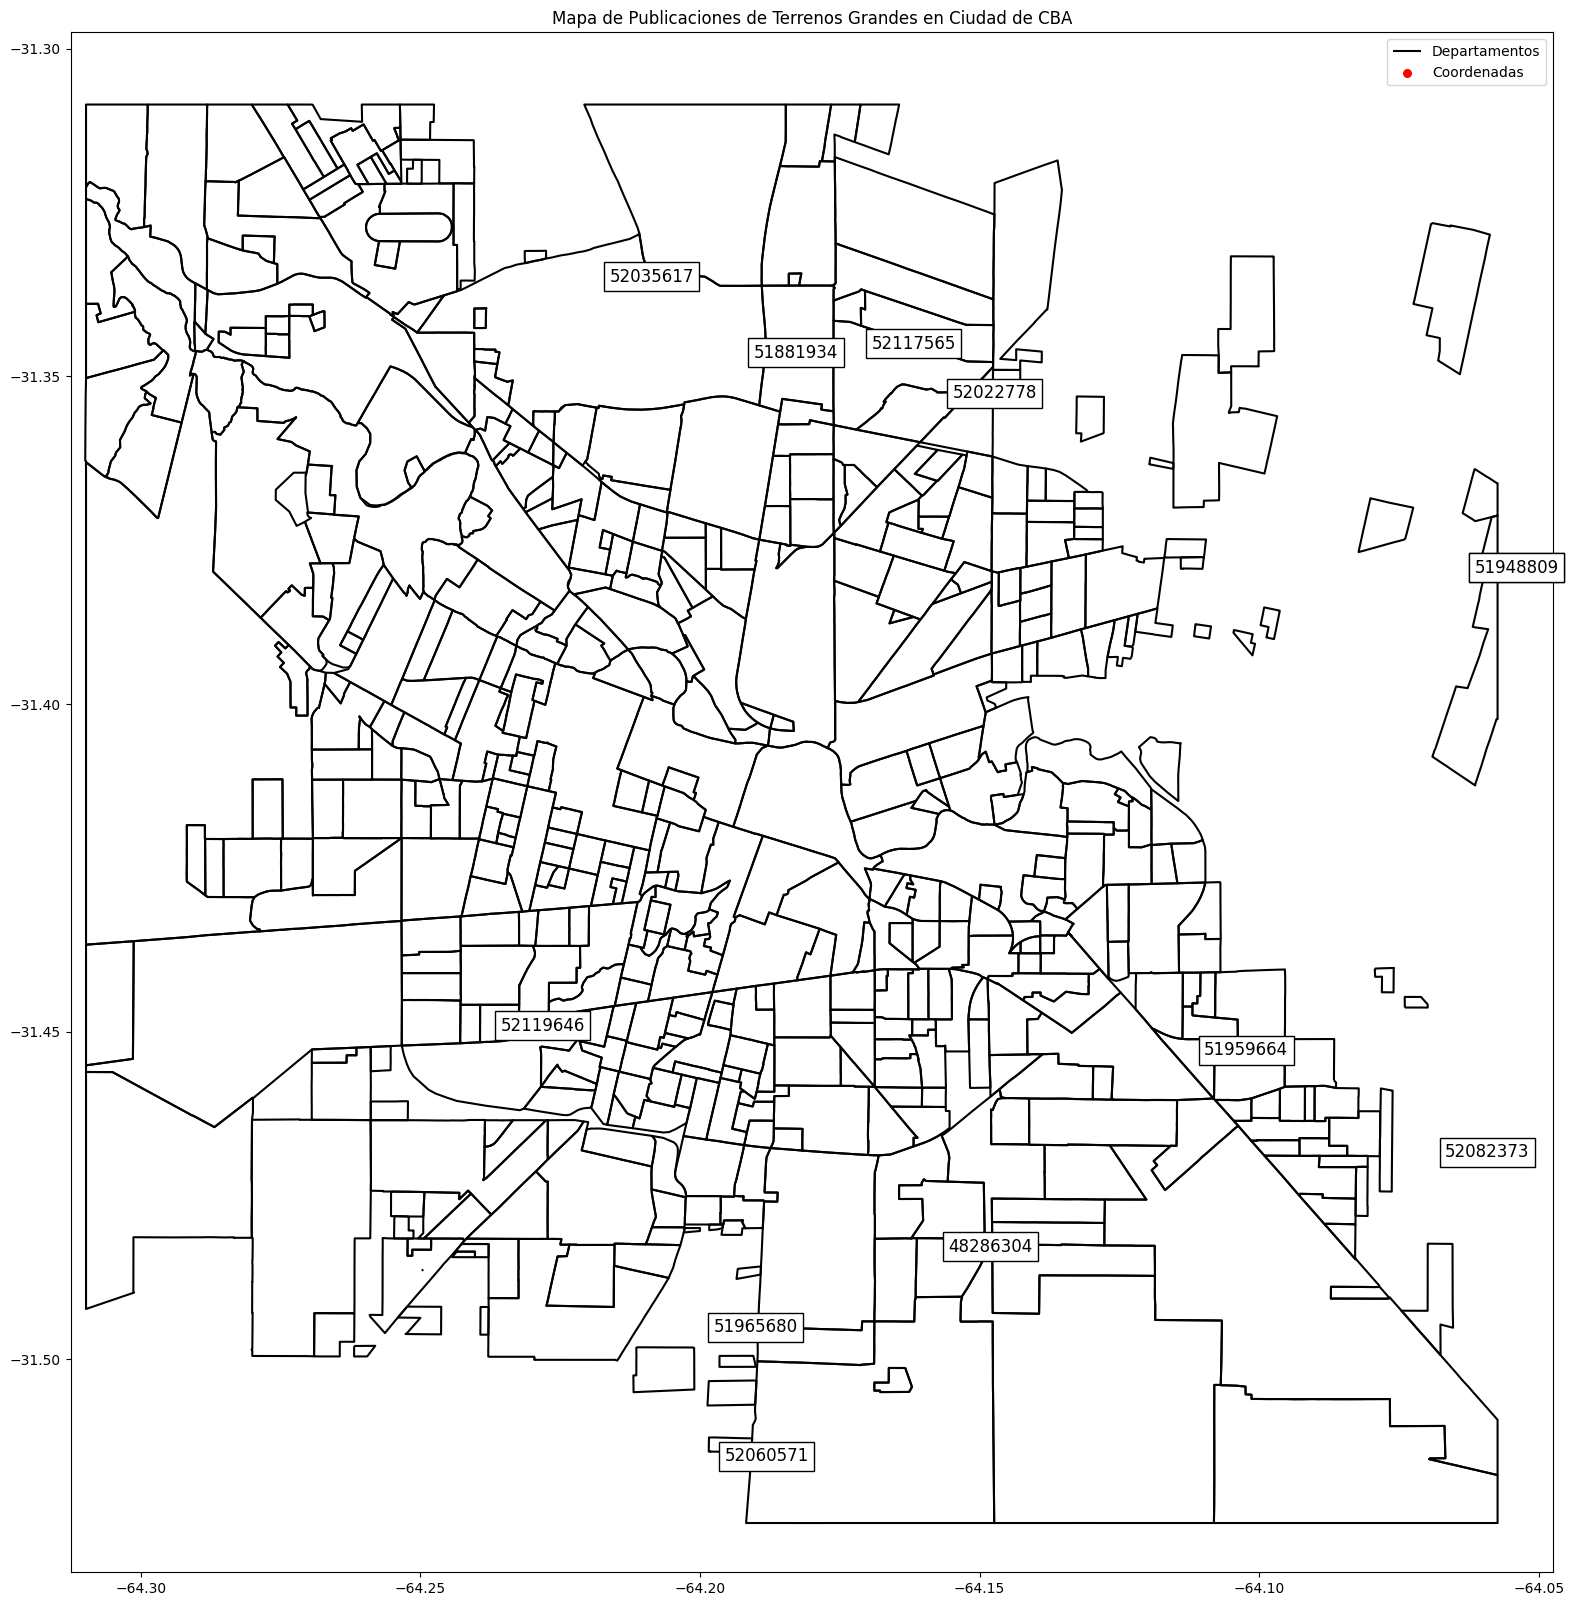

In [16]:
# ANALISIS TERRENOS

# Terrenos grandes: para desarrollos
filt = (terrenos['terrenoTotal'] >= 10000) & (terrenos['ciudad'] == 'CORDOBA') & terrenos['activo']
terrenos_grandes = terrenos.loc[filt]


import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame terrenos_grandes with columns 'coordX', 'coordY', and 'id'

# Read the shapefiles
barrios_shp = './utils/maps/barrios.shp'
barrios = gpd.read_file(barrios_shp)
center = (-64.18365408774824, -31.41675384652835)

# Create a plot with the boundaries of both shapefiles
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the boundaries of barrios shapefile
barrios.boundary.plot(ax=ax, color='black', label='Departamentos')

# Plot the points
scatter = ax.scatter(terrenos_grandes['coordY'], terrenos_grandes['coordX'], color='red', label='Coordenadas', s=30)

# Add labels for each point
for idx, row in terrenos_grandes.iterrows():
    ax.annotate(str(row['id']), (row['coordY'], row['coordX']), fontsize=12,
                ha='center', va='center', color='black', backgroundcolor='white', bbox=dict(facecolor='white', edgecolor='black'))

map_padding = 0.0125  # Increase the padding for more zoom-out effect
ax.set_xlim(-64.30 - map_padding, -64.06 + map_padding)
ax.set_ylim(-31.52 - map_padding, -31.31 + map_padding)

# Set the title and legend
ax.set_title('Mapa de Publicaciones de Terrenos Grandes en Ciudad de CBA')
ax.legend()

# Show the plot
plt.savefig(f"output_map.png", dpi=300, bbox_inches="tight")
plt.show()

filt = (terrenos_grandes['coordY'].between((-64.30-map_padding), (-64.06 + map_padding)) 
        & terrenos_grandes['coordX'].between((-31.52-map_padding), (-31.31 + map_padding)))
resultados = terrenos_grandes.loc[filt]
results_df = resultados[['id','precioUSD', 'terrenoTotal', 'URL']]
# Assuming you have a DataFrame named 'results_df' and you want to save it to an Excel file named 'results.xlsx'
results_df.to_excel('./DataFrames/ZonaP/Analisis/Terrenos/terrenos_grandes_ZP.xlsx', index=False)

In [17]:
# DOCTA
filt = (df['barrio'].str.contains('DOCTA') | df['URL'].str.contains('DOCTA')) & (df['ciudad'] == 'CORDOBA') & df['activo']
resultados = df[filt]

results_df = resultados[['id','tipoPropiedad','precioUSD','fechaUltimaActualizacion','vendedor','terrenoTotal','terrenoEdificado','cantDormitorios','cantBanos','cantCochera','barrio','URL']]
# Assuming you have a DataFrame named 'results_df' and you want to save it to an Excel file named 'results.xlsx'
results_df.to_excel('./DataFrames/ZonaP/Analisis/Inmuebles/Manantiales-Docta/docta_ZP.xlsx', index=False)

In [18]:
# MANANTIALES
filt = (df['barrio'].str.contains('MANANTIALES') | df['URL'].str.contains('MANANTIALES')) & (df['ciudad'] == 'CORDOBA') & df['activo']
resultados = df[filt]

results_df = resultados[['id','tipoPropiedad','precioUSD','fechaUltimaActualizacion','vendedor','terrenoTotal','terrenoEdificado','cantDormitorios','cantBanos','cantCochera','barrio','URL']]
# Assuming you have a DataFrame named 'results_df' and you want to save it to an Excel file named 'results.xlsx'
results_df.to_excel('./DataFrames/ZonaP/Analisis/Inmuebles/Manantiales-Docta/manantiales_ZP.xlsx', index=False)

In [19]:
#Apto
filt = (terrenos['URL'].str.contains('apto') | terrenos['URL'].str.contains('dup')) & terrenos['activo']
results_df = terrenos.loc[filt, ['id','precioUSD', 'terrenoTotal', 'fechaUltimaActualizacion', 'URL']]
results_df.to_excel('./DataFrames/ZonaP/Analisis/Terrenos/apto_duplex_ZP.xlsx', index=False)
results_df


,id,precioUSD,terrenoTotal,fechaUltimaActualizacion,URL
74,52088997,100000,3000.0,31-07-2023,https://www.zonaprop.com.ar/propiedades/lote-e...
175,52089524,29500,350.0,31-07-2023,https://www.zonaprop.com.ar/propiedades/lote-p...
190,52086164,100000,440.0,31-07-2023,https://www.zonaprop.com.ar/propiedades/venta-...
198,52086128,75000,200.0,31-07-2023,https://www.zonaprop.com.ar/propiedades/terren...
200,52087812,25000,250.0,31-07-2023,https://www.zonaprop.com.ar/propiedades/venta-...
672,51936564,35000,360.0,30-06-2023,https://www.zonaprop.com.ar/propiedades/venta-...
1191,51925918,24999,360.0,29-06-2023,https://www.zonaprop.com.ar/propiedades/venta-...
1814,51916839,39500,306.0,28-06-2023,https://www.zonaprop.com.ar/propiedades/venta-...
1888,51909219,45000,413.0,28-06-2023,https://www.zonaprop.com.ar/propiedades/terren...
2429,52070832,44900,364.0,27-07-2023,https://www.zonaprop.com.ar/propiedades/prados...
